# <a name="0">Machine Learning Lab

Build a classfier to predict the __label__ field (substitute or not substitute) of the product substitute dataset.

### Final Project Problem: Product Substitute Prediction

__Problem Definition__:
Given a pair of products, (A, B), we say that B is a "substitute" for A if a customer would buy B in place of A -- say, if A were out of stock.

The goal of this project is to predict a substitute relationship between pairs of products. Complete the tasks in this notebook and submit your notebook via Colab  

1. <a href="#1">Read the datasets</a> (Given)
2. <a href="#2">Data Processing</a> (Implement)
    * <a href="#21">Exploratory Data Analysis</a>
    * <a href="#22">Select features to build the model</a> (Suggested)
    * <a href="#23">Train - Validation - Test Datasets</a>
    * <a href="#24">Data Processing with Pipeline</a>
3. <a href="#3">Train (and Tune) a Classifier on the Training Dataset</a> (Implement)
4. <a href="#3">Make Predictions on the Test Dataset</a> (Implement)


__Datasets and Files:__


* __training.csv__: Training data with product pair features and corresponding labels:
> - `ID:` ID of the record
> - `label:` Tells whether the key and candidate products are substitutes (1) or not (0).
> - `key_asin ...:` Key product ASIN features
> - `cand_asin ...:` Candidate product ASIN features


* __public_test_features.csv__: Test data with product pairs features __without__ labels:
> - `ID:` ID of the record
> - `key_asin ...:` Key product ASIN features
> - `cand_asin ...:` Candidate product ASIN features


* __metadata-dataset.xlsx__: Provides detailed information about all key_ and cand_ columns in the training and test sets. Try to select some useful features to include in the model, as not all of them are suitable. `|Region Id|MarketPlace Id|ASIN|Binding Code|binding_description|brand_code|case_pack_quantity|, ...`


## 1. <a name="1">Read the datasets</a> (Given)
(<a href="#0">Go to top</a>)
</br>
<a href="https://propensity-labs-screening.s3.amazonaws.com/machine_learning/ml_data.zip">Download Dataset</a>

Then, we read the __training__ and __test__ datasets into dataframes

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/content/training.csv', low_memory=False)
df.head()

,ID,label,key_Region Id,key_MarketPlace Id,key_ASIN,key_Binding Code,key_binding_description,key_brand_code,key_case_pack_quantity,key_classification_code,...,cand_pkg_weight,cand_pkg_weight_uom,cand_pkg_width,cand_release_date_embargo_level,cand_dw_creation_date,cand_dw_last_updated,cand_is_deleted,cand_last_updated,cand_version,cand_external_testing_certification
0,34016,0,1,1,B00YCZ6IKA,kitchen,Kitchen,NICLW,NaN,base_product,...,0.529104,pounds,5.118110,NaN,18-Apr-13,14-Oct-17,N,13-Oct-17,2867,NaN
1,3581,0,1,1,B00U25WT7A,office_product,Office Product,NaN,NaN,base_product,...,0.100000,pounds,4.500000,NaN,19-May-16,21-Mar-18,N,20-Mar-18,65,NaN
2,36025,1,1,1,B011BZ3GXU,consumer_electronics,Electronics,NaN,NaN,base_product,...,0.654773,pounds,3.937008,NaN,10-Dec-15,16-Feb-18,N,15-Feb-18,1532,NaN
3,42061,1,1,1,B0089XDG3I,pc,Personal Computers,NaN,NaN,base_product,...,3.549442,pounds,10.314961,NaN,19-Oct-12,15-Feb-18,N,14-Feb-18,13964,NaN
4,14628,1,1,1,B014UTSBZW,miscellaneous,Misc.,ZUKC7,1.0,base_product,...,0.396832,pounds,5.196850,NaN,26-Jul-12,9-Mar-18,N,9-Mar-18,1253,NaN


## 2. <a name="2">Data Processing</a> (Implement)
(<a href="#0">Go to top</a>)

### 2.1 <a name="21">Exploratory Data Analysis</a>

We look at number of rows, columns, and some simple statistics of the datasets.

In [ ]:
# Implement EDA here


### 2.2 <a name="22">Select features to build the model</a>

For a quick start, we recommend using only a few of the numerical features for both key_ and cand_ ASINs: __item_package_quantity__, __item_height__, __item_width__, __item_length__, __item_weight__, __pkg_height__, __pkg_width__, __pkg_length__, __pkg_weight__. Feel free to explore other fields from the metadata-dataset.xlsx file.


In [3]:
# Implement here
df_new = df[['key_item_package_quantity','key_item_height','key_item_width','key_item_length','key_item_weight','key_pkg_height','key_pkg_width','key_pkg_length','key_pkg_weight','cand_item_package_quantity','cand_item_height','cand_item_width','cand_item_length','cand_item_weight','cand_pkg_width','cand_pkg_length','cand_pkg_weight']]
df_new.head()

,key_item_package_quantity,key_item_height,key_item_width,key_item_length,key_item_weight,key_pkg_height,key_pkg_width,key_pkg_length,key_pkg_weight,cand_item_package_quantity,cand_item_height,cand_item_width,cand_item_length,cand_item_weight,cand_pkg_width,cand_pkg_length,cand_pkg_weight
0,1.0,1.00,66.00,86.00,6.000000,10.0,15.0,20.0,6.300000,1.0,0.00000,18.00000,40.0000,0.530000,5.118110,18.110236,0.529104
1,6.0,2.00,0.10,2.50,NaN,0.2,4.0,4.8,0.022046,1.0,0.30000,4.50000,6.7500,0.110231,4.500000,6.750000,0.100000
2,1.0,0.83,2.24,5.94,0.789375,2.1,4.6,7.2,1.050000,1.0,0.86614,3.62204,2.3622,0.396832,3.937008,5.236220,0.654773
3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.36000,20.29000,10.2400,3.480000,10.314961,20.590551,3.549442
4,1.0,9.33,7.50,2.75,0.438000,0.2,7.5,9.2,0.250000,1.0,8.50000,9.87500,11.7500,NaN,5.196850,7.874016,0.396832


<Axes: >

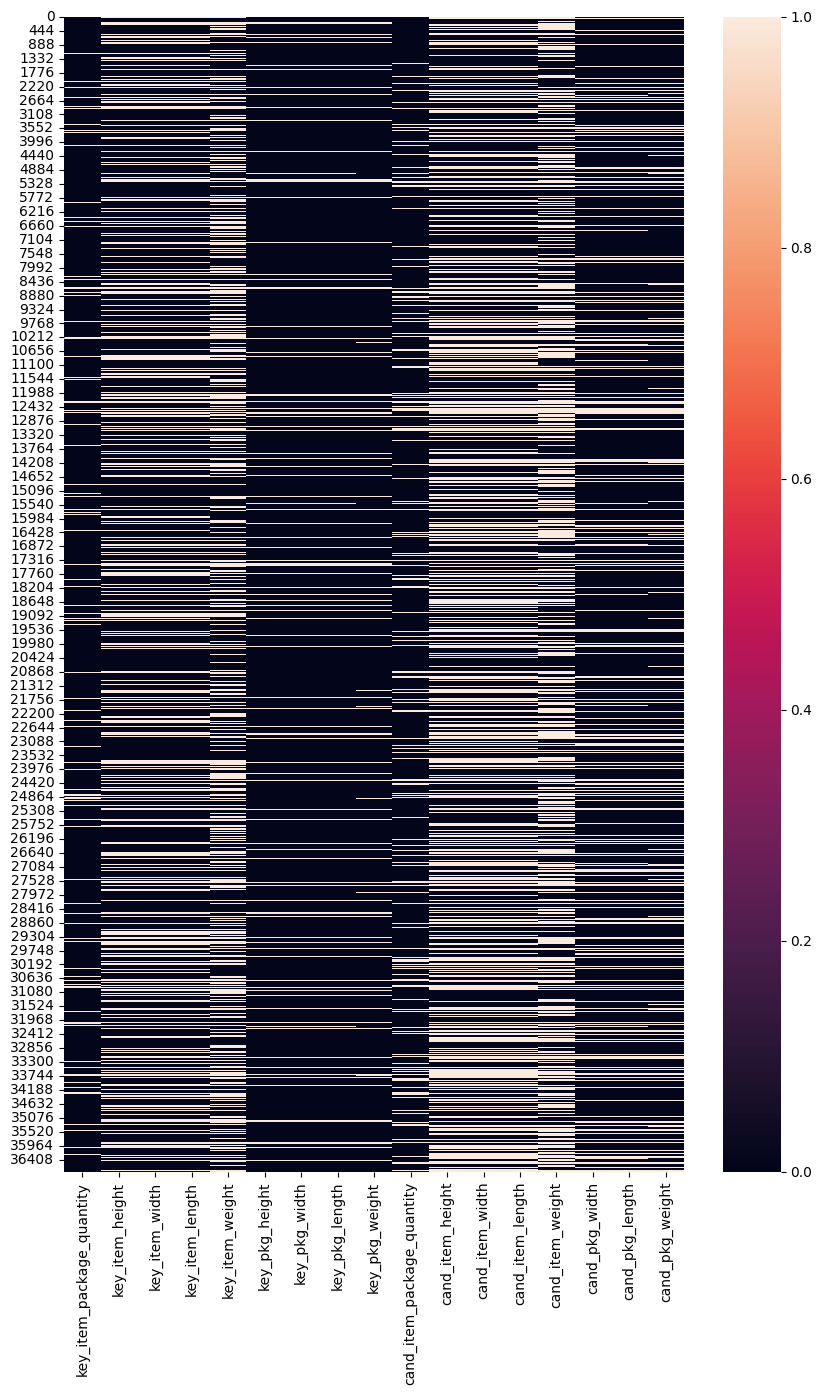

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,15))
sns.heatmap(df_new.isnull())

In [5]:
df_new.isnull().sum()/len(df_new) * 100

key_item_package_quantity      8.271065
key_item_height               28.122707
key_item_width                28.122707
key_item_length               28.122707
key_item_weight               38.496862
key_pkg_height                 9.360650
key_pkg_width                  9.360650
key_pkg_length                 9.360650
key_pkg_weight                 9.817134
cand_item_package_quantity    14.610222
cand_item_height              40.589082
cand_item_width               40.589082
cand_item_length              40.589082
cand_item_weight              47.854794
cand_pkg_width                20.101622
cand_pkg_length               20.101622
cand_pkg_weight               20.835258
dtype: float64

<Axes: >

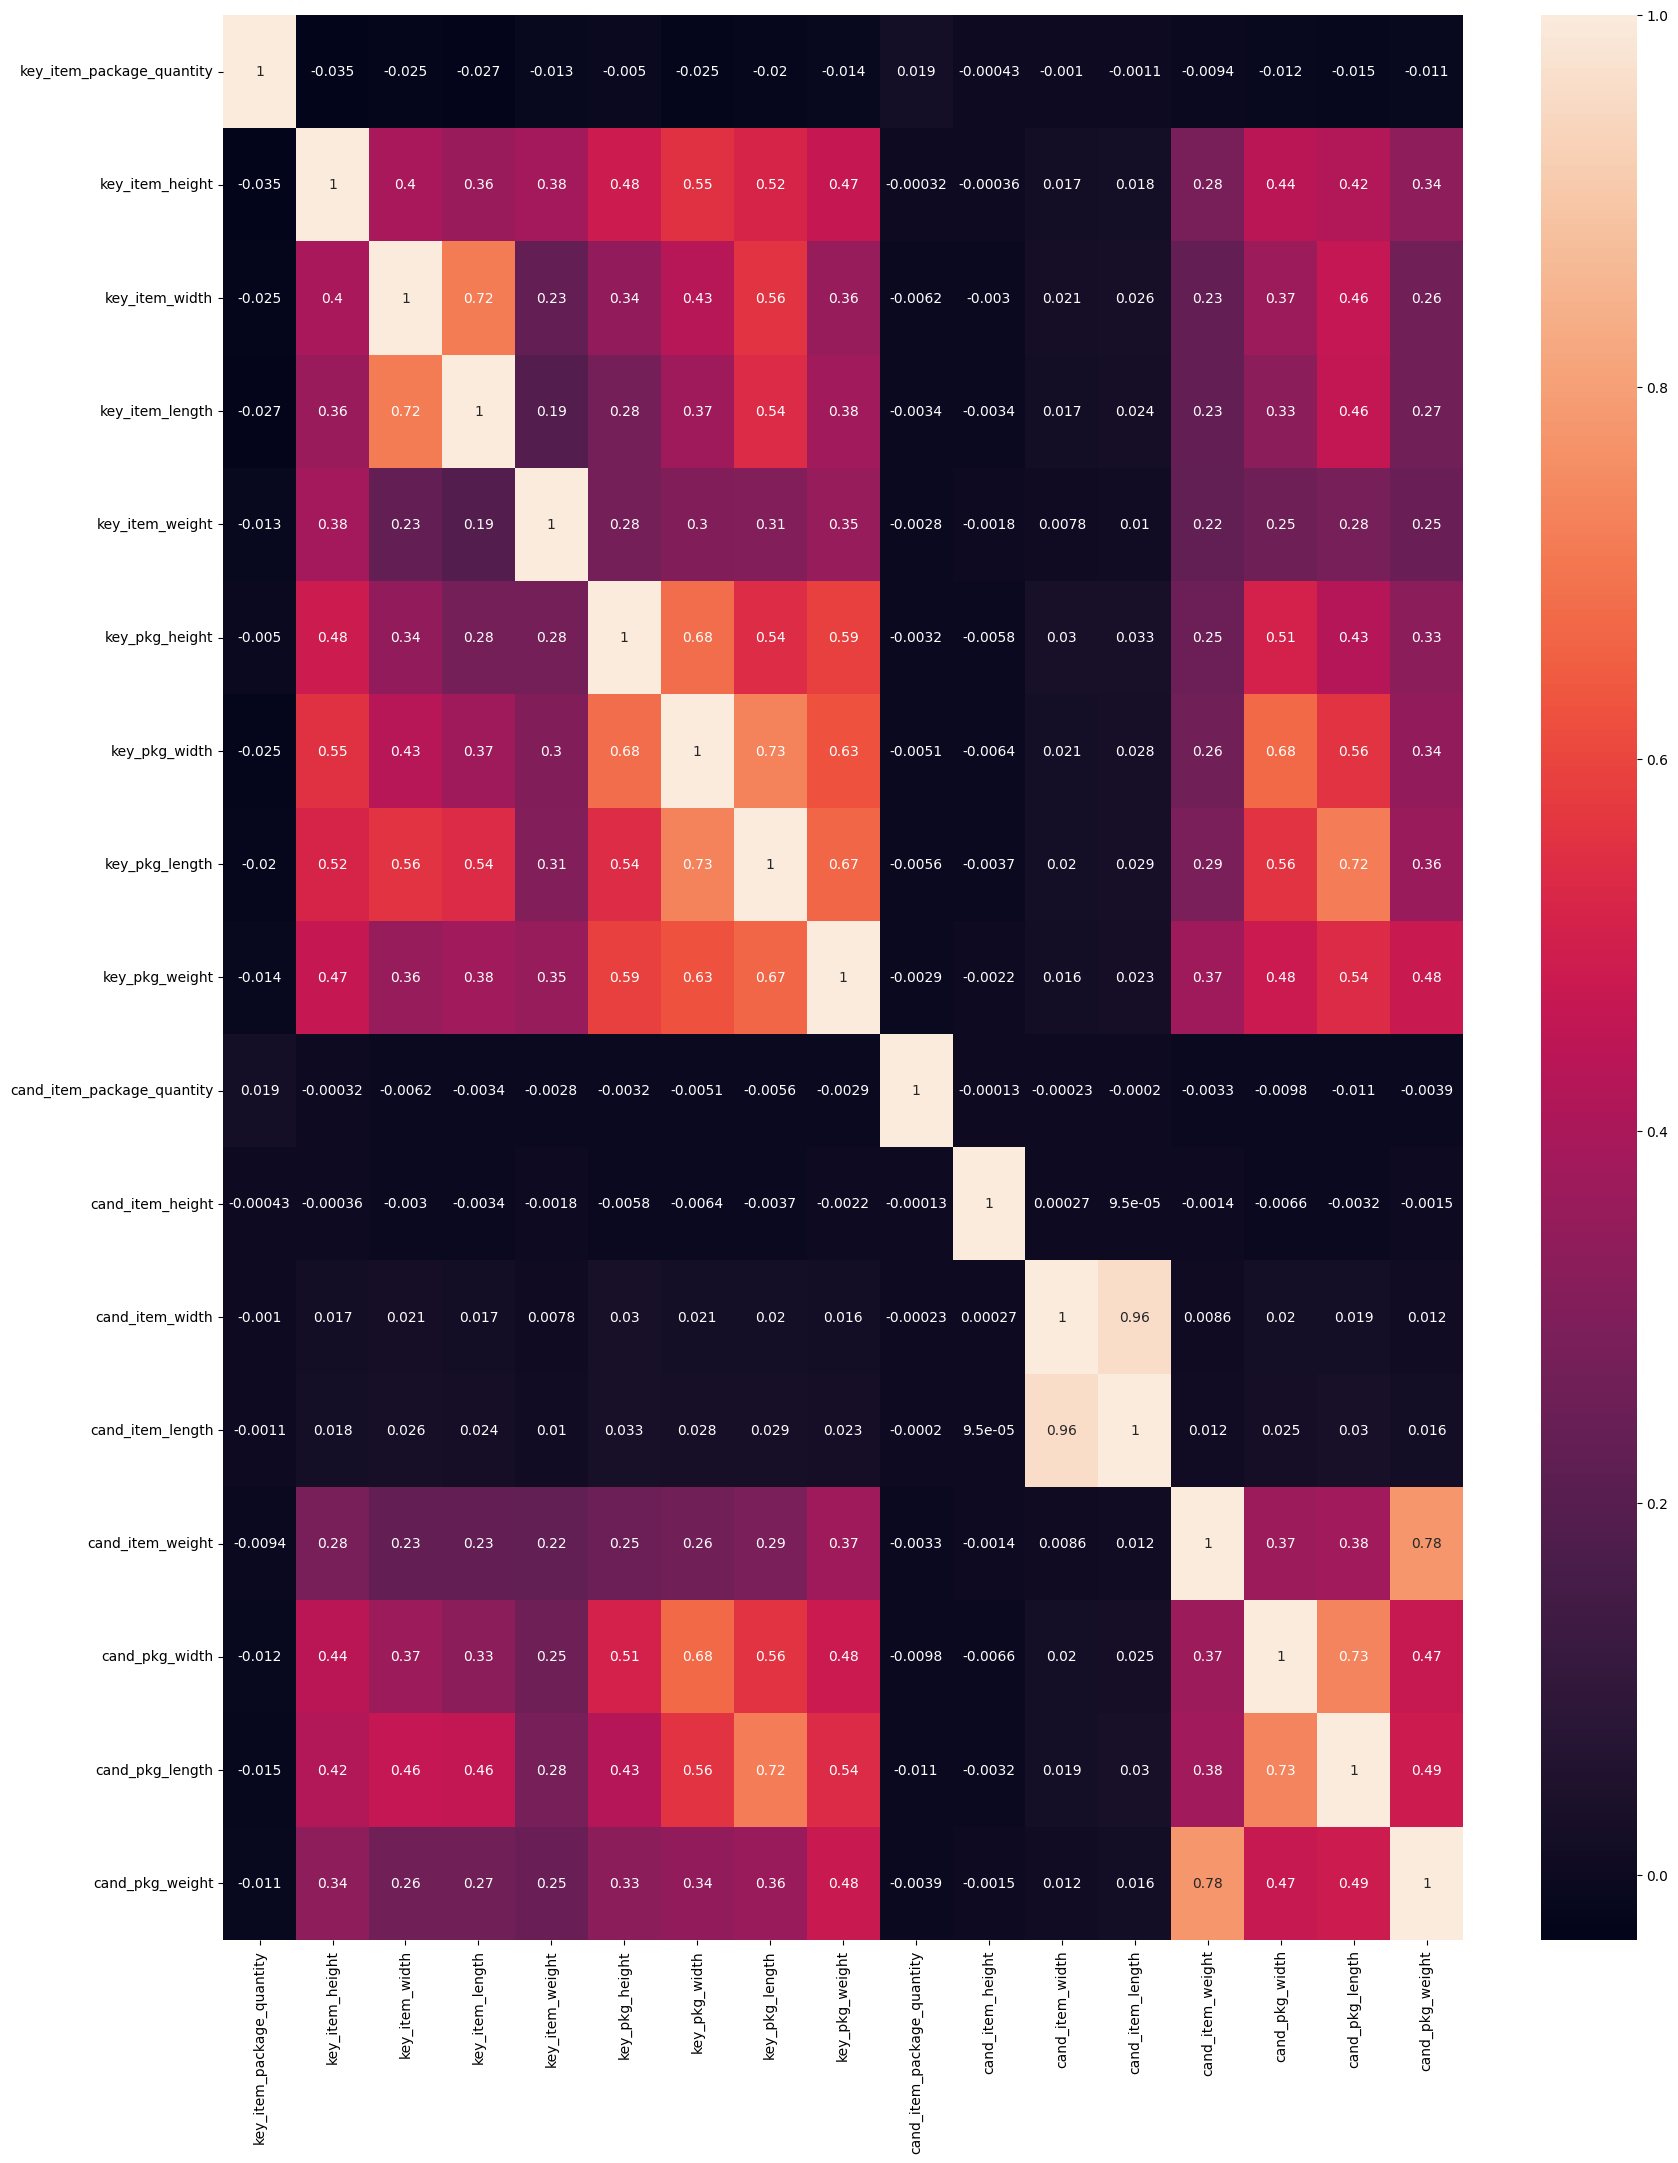

In [6]:
plt.figure(figsize = (20,25))
sns.heatmap(df_new.corr(), annot=True)

In [7]:
from scipy.stats import skew, kurtosis
for col in df_new.columns:
  print(col, end=" ")
  print(skew(df_new[col].dropna()))

key_item_package_quantity 28.424836093628382
key_item_height 4.65481081658267
key_item_width 5.710650024858558
key_item_length 7.042665499734387
key_item_weight 14.134287335416538
key_pkg_height 2.555579335268107
key_pkg_width 2.089364320231365
key_pkg_length 3.186035178174481
key_pkg_weight 7.854065646293878
cand_item_package_quantity 78.30050978850196
cand_item_height 147.85800869898287
cand_item_width 121.42841497670562
cand_item_length 104.6841644359478
cand_item_weight 34.17348966967772
cand_pkg_width 2.6730675673090882
cand_pkg_length 3.7448120312549946
cand_pkg_weight 36.910905975982494


In [8]:
for col in df_new.columns:
  if (df_new[col].isnull().sum()/36803)*100 > 10:
    df_new[col].fillna(df_new[col].median(), inplace=True)

<ipython-input-8-b0b6e55c99dc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[col].fillna(df_new[col].median(), inplace=True)
<ipython-input-8-b0b6e55c99dc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[col].fillna(df_new[col].median(), inplace=True)
<ipython-input-8-b0b6e55c99dc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[col].fillna(df_new[col].median(), inplace=True)
<ipython-input-8-b0b6e55c99dc>:3: 

In [9]:
df_new['key_item_package_quantity'].fillna(df_new['key_item_package_quantity'].mean(), inplace=True)
df_new['key_pkg_height'].fillna(df_new['key_pkg_height'].mean(), inplace=True)
df_new['key_pkg_width'].fillna(df_new['key_pkg_width'].mean(), inplace=True)
df_new['key_pkg_length'].fillna(df_new['key_pkg_length'].mean(), inplace=True)
df_new['key_pkg_weight'].fillna(df_new['key_pkg_weight'].mean(), inplace=True)

<ipython-input-9-6494daffb055>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['key_item_package_quantity'].fillna(df_new['key_item_package_quantity'].mean(), inplace=True)
<ipython-input-9-6494daffb055>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['key_pkg_height'].fillna(df_new['key_pkg_height'].mean(), inplace=True)
<ipython-input-9-6494daffb055>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['key_pkg_wid

### 2.3 <a name="23">Train - Validation Datasets</a>
(<a href="#2">Go to Data Processing</a>)

We already have training and test datasets, however the test dataset is missing the labels - the goal of the project is to predict these labels.

To produce a validation set to evaluate model performance before submitting  split the training dataset into train and validation. Validation data you get here will be used later in section 3 to tune your classifier.

In [10]:
# Implement here
X = df.iloc[:, 2:]
y = df.iloc[:,1]

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df_new,y, test_size=0.2, random_state=42)

In [12]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)

In [13]:
X_val_scaled = scalar.transform(X_val)

### 2.4 <a name="24">Data processing with Pipeline</a>

Build a [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)  to impute the missing values and scale the numerical features, and finally train the classifier on the imputed and scaled dataset.


In [ ]:
# Implement here


## 3. <a name="3">Train (and Tune) a Classifier</a> (Implement)
(<a href="#0">Go to top</a>)

Train and tune the classifier

In [32]:
from sklearn.neighbors import KNeighborsClassifier

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature nam

Minimum error:- 0.472761853009102 at K = 1


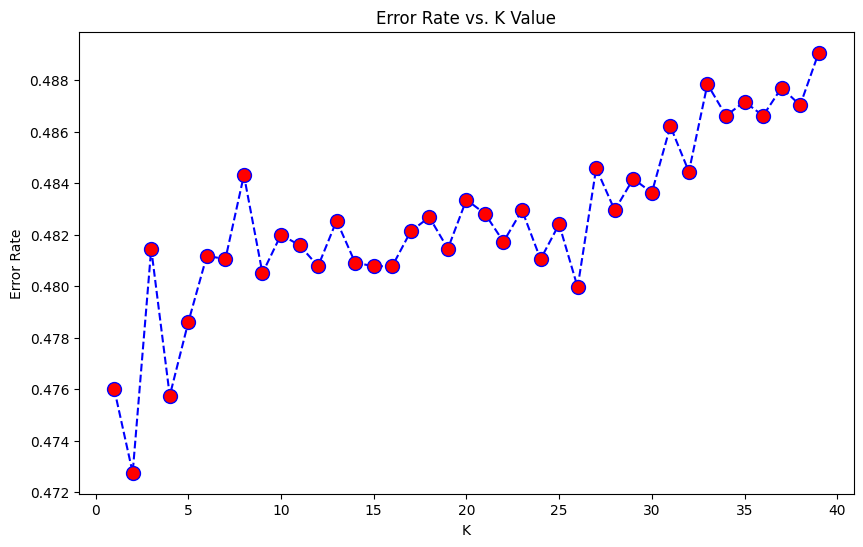

In [33]:
error_rate = []
for i in range(1,40):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train_scaled,y_train)
 pred_i = knn.predict(X_val)
 error_rate.append(np.mean(pred_i != y_val))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed',
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

In [36]:
clf_knn = KNeighborsClassifier(n_neighbors=1)
clf_knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=1)

In [37]:
print(accuracy_score(y_val, clf_knn.predict(X_val_scaled)))

0.587691889688901


In [38]:
# from scipy.stats import randint

# rs_space={'max_depth':list(np.arange(10, 100, step=10)) + [None],
#               'n_estimators':np.arange(10, 500, step=50),
#               'max_features':randint(1,7),
#               'criterion':['gini','entropy'],
#               'min_samples_leaf':randint(1,4),
#               'min_samples_split':np.arange(2, 10, step=2)
#          }


In [39]:
# from sklearn.model_selection import RandomizedSearchCV

# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(rf, rs_space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=3)
# model_random = rf_random.fit(X_train_scaled,y_train)

KeyboardInterrupt: 

In [ ]:
# print('Best hyperparameters are: '+str(model_random.best_params_))
# print('Best score is: '+str(model_random.best_score_))

In [14]:
# Implement here
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=400)
clf_rf.fit(X_train_scaled, y_train)


RandomForestClassifier(n_estimators=400)

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [17]:
y_pred_rf = clf_rf.predict(X_val_scaled)
print(accuracy_score(y_val, y_pred_rf))

0.6461078657791061


In [18]:
confusion_matrix(y_val, y_pred_rf)

array([[2287, 1350],
       [1255, 2469]])

In [19]:
classification_report(y_val, y_pred_rf)

'              precision    recall  f1-score   support\n\n           0       0.65      0.63      0.64      3637\n           1       0.65      0.66      0.65      3724\n\n    accuracy                           0.65      7361\n   macro avg       0.65      0.65      0.65      7361\nweighted avg       0.65      0.65      0.65      7361\n'

## 4. <a name="4">Make Predictions on the Test Dataset</a> (Implement)
(<a href="#0">Go to top</a>)

Use the trained classifier to predict the labels on the test set. Test accuracy would be displayed upon a valid submission to the leaderboard.

In [21]:
# Implement here

# Get test data to test the classifier
# ! test data should come from public_test_features.csv !
# ...

# Use the trained model to make predictions on the test dataset
# test_predictions = ...
df_test = pd.read_csv('/content/public_test_features.csv', low_memory=False)
df_test.head()

,ID,key_Region Id,key_MarketPlace Id,key_ASIN,key_Binding Code,key_binding_description,key_brand_code,key_case_pack_quantity,key_classification_code,key_classification_description,...,cand_pkg_weight,cand_pkg_weight_uom,cand_pkg_width,cand_release_date_embargo_level,cand_dw_creation_date,cand_dw_last_updated,cand_is_deleted,cand_last_updated,cand_version,cand_external_testing_certification
0,35057,1,1,B0096M8VR2,pc,Personal Computers,NaN,1.0,base_product,Base Product,...,0.925932,pounds,5.826772,NaN,10-Apr-13,5-Jul-16,N,4-Jul-16,699,NaN
1,41573,1,1,B00EAQJCWW,kitchen,Kitchen,BUNN9,2.0,base_product,Base Product,...,NaN,NaN,NaN,NaN,17-Mar-16,17-Mar-16,N,17-Mar-16,2,NaN
2,44029,1,1,B013P93YOQ,toy,Toy,NaN,NaN,base_product,Base Product,...,NaN,NaN,NaN,NaN,23-Dec-15,2-Dec-17,N,2-Dec-17,17,NaN
3,6462,1,1,B00SKJPKGW,wireless_phone_accessory,Wireless Phone Accessory,PIQ22,1.0,base_product,Base Product,...,6.250000,pounds,9.700000,NaN,22-Jan-15,18-Jan-17,N,18-Jan-17,25351,NaN
4,17533,1,1,B001DCEKXM,sports,Sports,SUUNR,1.0,base_product,Base Product,...,0.176368,pounds,3.228346,NaN,4-Jan-11,16-Nov-17,N,16-Nov-17,7424,NaN


In [22]:
# Implement here
df_new_test = df_test[['key_item_package_quantity','key_item_height','key_item_width','key_item_length','key_item_weight','key_pkg_height','key_pkg_width','key_pkg_length','key_pkg_weight','cand_item_package_quantity','cand_item_height','cand_item_width','cand_item_length','cand_item_weight','cand_pkg_width','cand_pkg_length','cand_pkg_weight']]
df_new_test.head()

,key_item_package_quantity,key_item_height,key_item_width,key_item_length,key_item_weight,key_pkg_height,key_pkg_width,key_pkg_length,key_pkg_weight,cand_item_package_quantity,cand_item_height,cand_item_width,cand_item_length,cand_item_weight,cand_pkg_width,cand_pkg_length,cand_pkg_weight
0,1.0,0.728345,4.80314,11.18108,0.42,1.102362,4.881890,11.614173,0.500449,1.0,0.748030,4.803140,11.220450,0.660000,5.826772,12.047244,0.925932
1,1.0,9.100000,13.70000,11.60000,8.00,10.511811,12.519685,15.236220,8.198992,NaN,NaN,NaN,NaN,0.350000,NaN,NaN,NaN
2,1.0,8.000000,2.00000,10.00000,NaN,1.496063,7.362205,10.078740,0.350535,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,3.875000,7.00000,6.50000,4.90,6.400000,9.700000,11.000000,6.530000,1.0,3.875000,7.000000,6.500000,4.590000,9.700000,11.100000,6.250000
4,1.0,1.930000,0.57000,1.93000,NaN,3.543307,3.740157,5.118110,0.088185,1.0,0.003937,0.003937,0.003937,0.110231,3.228346,8.818898,0.176368


In [26]:
df_new_test.isnull().sum()/15774 *100

key_item_package_quantity      7.842019
key_item_height               27.545328
key_item_width                27.545328
key_item_length               27.545328
key_item_weight               38.265500
key_pkg_height                 9.192342
key_pkg_width                  9.192342
key_pkg_length                 9.192342
key_pkg_weight                 9.712185
cand_item_package_quantity    14.663370
cand_item_height              40.376569
cand_item_width               40.376569
cand_item_length              40.376569
cand_item_weight              47.261316
cand_pkg_width                20.540129
cand_pkg_length               20.540129
cand_pkg_weight               21.136047
dtype: float64

In [25]:
df_new_test.shape

(15774, 17)

In [27]:
for col in df_new_test.columns:
  df_new_test[col].fillna(df_new_test[col].median(), inplace=True)
df_new_test.isnull().sum()

<ipython-input-27-ff49f12ec578>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_test[col].fillna(df_new_test[col].median(), inplace=True)
<ipython-input-27-ff49f12ec578>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_test[col].fillna(df_new_test[col].median(), inplace=True)
<ipython-input-27-ff49f12ec578>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_test[col].fillna(df_new_test[col].median(), inplace=True)
<

key_item_package_quantity     0
key_item_height               0
key_item_width                0
key_item_length               0
key_item_weight               0
key_pkg_height                0
key_pkg_width                 0
key_pkg_length                0
key_pkg_weight                0
cand_item_package_quantity    0
cand_item_height              0
cand_item_width               0
cand_item_length              0
cand_item_weight              0
cand_pkg_width                0
cand_pkg_length               0
cand_pkg_weight               0
dtype: int64

In [29]:
X_test = scalar.transform(df_new_test)

In [30]:
y_pred_test = clf_rf.predict(X_test)

In [31]:
y_output = []
for i in y_pred_test:
  if i>0.5:
    y_output.append(1)
  else:
    y_output.append(0)


[1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 

In [ ]:
#Predicted output
print(y_output)